# Brain Tumor Classification using Deep Learning (DenseNet121, Grad-CAM)

기존 데이터셋은 training, test 폴더로만 구성되어 있음 -> traning의 20%를 validation으로 split

가상환경: source ~/tf-metal-venv/bin/activate

다중 분류: softmax

In [ ]:
import os
import shutil
import random
from pathlib import Path

# 설정
BASE_DIR = Path('dataset/classification')
TRAIN_DIR = BASE_DIR / 'training'
VAL_DIR = BASE_DIR / 'val'
SPLIT_RATIO = 0.2
RANDOM_SEED = 42

# val 디렉토리 초기화
if VAL_DIR.exists():
    shutil.rmtree(VAL_DIR)
VAL_DIR.mkdir(parents=True, exist_ok=True)

# 클래스별 이동
random.seed(RANDOM_SEED)
for class_name in os.listdir(TRAIN_DIR):
    class_path = TRAIN_DIR / class_name
    if not class_path.is_dir():
        continue

    val_class_dir = VAL_DIR / class_name
    val_class_dir.mkdir(parents=True, exist_ok=True)

    # 이미지 파일 리스트
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    n_total = len(img_files)
    n_val = int(n_total * SPLIT_RATIO)
    val_samples = random.sample(img_files, n_val)

    # 파일 이동
    for fname in val_samples:
        src = class_path / fname
        dst = val_class_dir / fname
        shutil.move(src, dst)

    print(f"{class_name}: 총 {n_total}개 중 {n_val}개 → val로 이동 완료")

print("\n validation 세트 분리 완료")

In [10]:
import os
from collections import defaultdict

def count_images_by_class(base_dir):
    class_counts = defaultdict(int)

    for class_name in sorted(os.listdir(base_dir)):
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        num_files = len([
            f for f in os.listdir(class_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        class_counts[class_name] = num_files
    return class_counts

# 루트 디렉토리
ROOT = 'dataset/classification'

# 출력
for subset in ['training', 'val', 'test']:
    dir_path = os.path.join(ROOT, subset)
    print(f"\n {subset.upper()} 클래스별 분포:")
    class_counts = count_images_by_class(dir_path)
    for cls, count in class_counts.items():
        print(f"  {cls:<12} : {count}개")


 TRAINING 클래스별 분포:
  glioma       : 1057개
  meningioma   : 1072개
  notumor      : 1276개
  pituitary    : 1166개

 VAL 클래스별 분포:
  glioma       : 264개
  meningioma   : 267개
  notumor      : 319개
  pituitary    : 291개

 TEST 클래스별 분포:
  glioma       : 300개
  meningioma   : 306개
  notumor      : 405개
  pituitary    : 300개


EfficientNetB0 (no tuning)

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# 경로 설정
BASE_DIR = 'dataset/classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'training')
VAL_DIR = os.path.join(BASE_DIR, 'val')
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 4

# 데이터 전처리
train_datagen = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip=True,
                                    rotation_range=20,
                                    zoom_range=0.2)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 모델 구성
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output, name='en1')

# 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 학습
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# 저장
model.save('en1.keras')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Epoch 1/10
143/143 [==============================] - 97s 605ms/step - loss: 0.3760 - accuracy: 0.8585 - val_loss: 2.7763 - val_accuracy: 0.2796
Epoch 2/10
143/143 [==============================] - 80s 558ms/step - loss: 0.2595 - accuracy: 0.9057 - val_loss: 1.8386 - val_accuracy: 0.2796
Epoch 3/10
143/143 [==============================] - 91s 633ms/step - loss: 0.2612 - accuracy: 0.9042 - val_loss: 2.6115 - val_accuracy: 0.2796
Epoch 4/10
143/143 [==============================] - 97s 675ms/step - loss: 0.2370 - accuracy: 0.9072 - val_loss: 4.6667 - val_accuracy: 0.2796
Epoch 5/10
143/143 [==============================] - 109s 764ms/step - loss: 0.2112 - accuracy: 0.9221 - val_loss: 3.9087 - val_accuracy: 0.2796
Epoch 6/10
143/143 [==============================] - 101s 704ms/step - loss: 0.2119 - accuracy: 0.9199 - val_loss: 3.5407 - val_accuracy: 0.2796
Epoch 7/10
143/143 [========================

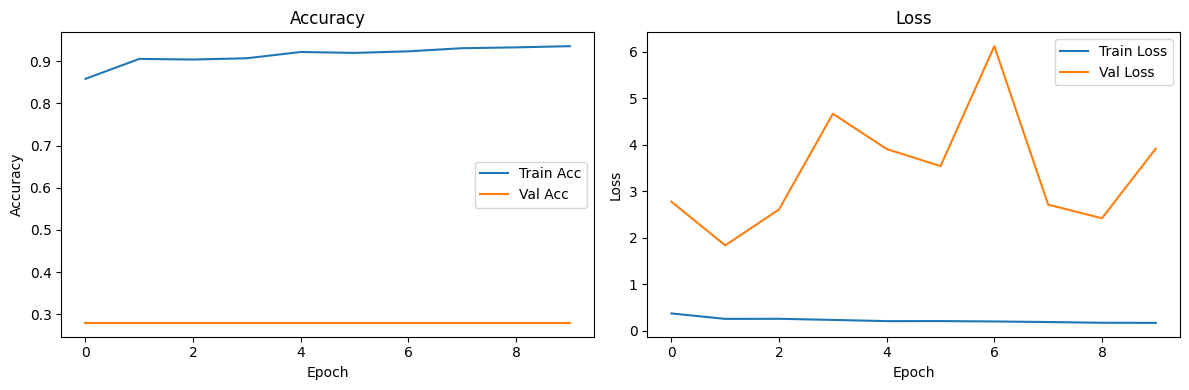

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 클래스 이름 추출
class_names = list(train_generator.class_indices.keys())

# 전체 validation 이미지에 대해 예측
val_generator.reset()
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report")
print(report)

36/36 [==============================] - 7s 150ms/step
Confusion Matrix
[[  0   0 264   0]
 [  0   0 267   0]
 [  0   0 319   0]
 [  0   0 291   0]]
Classification Report
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       264
  meningioma       0.00      0.00      0.00       267
     notumor       0.28      1.00      0.44       319
   pituitary       0.00      0.00      0.00       291

    accuracy                           0.28      1141
   macro avg       0.07      0.25      0.11      1141
weighted avg       0.08      0.28      0.12      1141



/Users/henrypark/tf-metal-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/henrypark/tf-metal-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/henrypark/tf-metal-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [8]:
print(train_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [14]:
# 예측 결과 예시
y_pred_probs = model.predict(val_generator)
print("Softmax 예측값 예시 (앞 5개):")
print(y_pred_probs[:5])

36/36 [==============================] - 5s 139ms/step
Softmax 예측값 예시 (앞 5개):
[[0.00272273 0.00588537 0.9868312  0.00456063]
 [0.00287534 0.00620437 0.9860269  0.00489343]
 [0.00281942 0.00615552 0.9861222  0.00490288]
 [0.00284816 0.00624642 0.98599803 0.00490746]
 [0.00280111 0.00610399 0.9863077  0.00478711]]


EfficientNetB0: Transfer Learning 안정화 (전체 layer 학습 가능하도록 튜닝)

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# 경로 설정
BASE_DIR = 'dataset/classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 15

# 데이터 로딩
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# class_weight 계산
class_labels = train_generator.classes
class_ids = list(train_generator.class_indices.values())
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weight_dict = dict(enumerate(class_weights))

# 모델 구성
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # 전체 tuning

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output, name='en2_full_finetune')

# 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

# 저장
model.save('en2_full_finetuned.keras')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


2025-05-30 17:15:36.253690: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-30 17:15:36.253707: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-30 17:15:36.253716: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-30 17:15:36.253744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-30 17:15:36.253757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2025-05-30 17:15:42.147673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-30 17:15:42.899851: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


143/143 [==============================] - 130s 851ms/step - loss: 0.5615 - accuracy: 0.8031 - val_loss: 1.3972 - val_accuracy: 0.2699 - lr: 1.0000e-04
Epoch 2/15
143/143 [==============================] - 107s 744ms/step - loss: 0.2540 - accuracy: 0.9112 - val_loss: 1.2928 - val_accuracy: 0.3339 - lr: 1.0000e-04
Epoch 3/15
143/143 [==============================] - 121s 842ms/step - loss: 0.1963 - accuracy: 0.9293 - val_loss: 1.2615 - val_accuracy: 0.4575 - lr: 1.0000e-04
Epoch 4/15
143/143 [==============================] - 110s 762ms/step - loss: 0.1602 - accuracy: 0.9438 - val_loss: 1.3912 - val_accuracy: 0.3541 - lr: 1.0000e-04
Epoch 5/15
143/143 [==============================] - 107s 745ms/step - loss: 0.1359 - accuracy: 0.9521 - val_loss: 1.3525 - val_accuracy: 0.2927 - lr: 1.0000e-04
Epoch 6/15
143/143 [==============================] - 110s 766ms/step - loss: 0.1112 - accuracy: 0.9635 - val_loss: 1.4933 - val_accuracy: 0.3339 - lr: 5.0000e-05


36/36 [==============================] - 6s 142ms/step


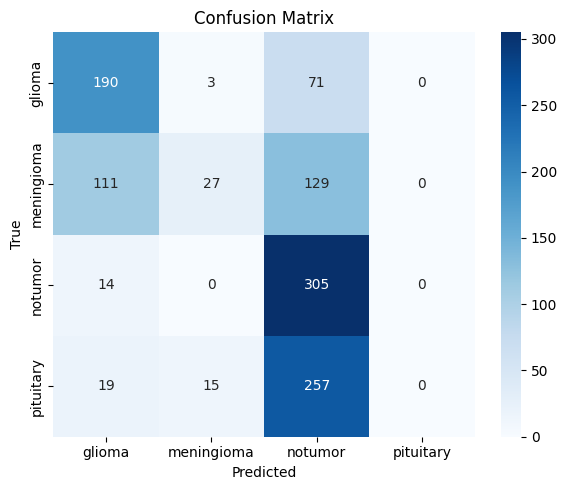

Classification Report:
               precision    recall  f1-score   support

      glioma       0.57      0.72      0.64       264
  meningioma       0.60      0.10      0.17       267
     notumor       0.40      0.96      0.56       319
   pituitary       0.00      0.00      0.00       291

    accuracy                           0.46      1141
   macro avg       0.39      0.44      0.34      1141
weighted avg       0.38      0.46      0.35      1141



/Users/henrypark/tf-metal-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/henrypark/tf-metal-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/henrypark/tf-metal-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름
class_names = list(train_generator.class_indices.keys())

# 예측
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

Fine-tuning ResNet50으로 모델 변경

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# 경로 설정
BASE_DIR = 'dataset/classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 15

# 1. 데이터 로딩
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 2. class_weight 계산
class_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(class_labels),
                                     y=class_labels)
class_weight_dict = dict(enumerate(class_weights))

# 3. ResNet50 기반 모델 구성 (Transfer Learning + fine-tuning)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # 전체 fine-tuning (학습 가중치만 적용)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output, name='resnet50_finetuned')

model.summary()

# 4. 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. 콜백
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# 6. 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

# 7. 저장
model.save('resnet50_finetuned.keras')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Model: "resnet50_finetuned"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']        

Epoch 1/15


2025-05-30 17:38:21.919194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


143/143 [==============================] - 125s 838ms/step - loss: 0.3048 - accuracy: 0.8882 - val_loss: 2.6471 - val_accuracy: 0.1946 - lr: 1.0000e-04
Epoch 2/15
143/143 [==============================] - 146s 1s/step - loss: 0.1376 - accuracy: 0.9521 - val_loss: 3.0155 - val_accuracy: 0.1858 - lr: 1.0000e-04
Epoch 3/15
143/143 [==============================] - 149s 1s/step - loss: 0.0849 - accuracy: 0.9713 - val_loss: 3.3831 - val_accuracy: 0.3243 - lr: 1.0000e-04
Epoch 4/15
143/143 [==============================] - 160s 1s/step - loss: 0.0453 - accuracy: 0.9875 - val_loss: 4.5361 - val_accuracy: 0.3024 - lr: 5.0000e-05


36/36 [==============================] - 8s 198ms/step


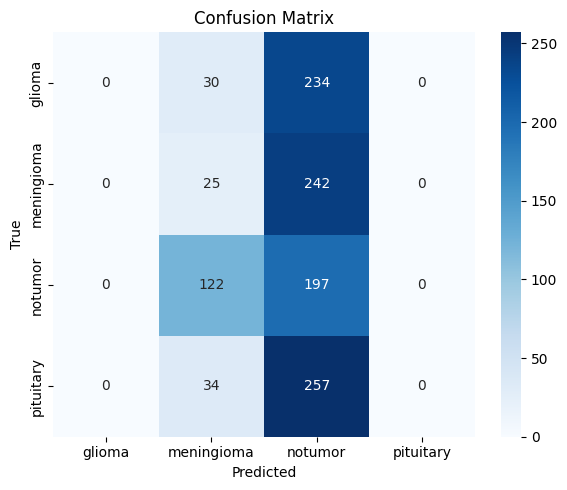

Classification Report:

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       264
  meningioma       0.12      0.09      0.10       267
     notumor       0.21      0.62      0.32       319
   pituitary       0.00      0.00      0.00       291

    accuracy                           0.19      1141
   macro avg       0.08      0.18      0.11      1141
weighted avg       0.09      0.19      0.11      1141



/Users/henrypark/tf-metal-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/henrypark/tf-metal-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/henrypark/tf-metal-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름
class_names = list(train_generator.class_indices.keys())

# 예측
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

DenseNet121

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# 경로 설정
BASE_DIR = 'dataset/classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 20

# 1. 데이터 로딩, 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=25,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 클래스 가중치 계산
class_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(class_labels),
                                     y=class_labels)
class_weight_dict = dict(enumerate(class_weights))

# DenseNet121 기반 모델 구성
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # 신경망 전체 학습

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output, name='densenet121_finetuned')

model.summary()

# 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 콜백
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

# 7. 모델 저장
model.save('densenet121_finetuned.keras')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


2025-05-30 17:58:09.209037: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-30 17:58:09.209058: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-30 17:58:09.209065: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-30 17:58:09.209092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-30 17:58:09.209104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "densenet121_finetuned"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/co

Epoch 1/20


2025-05-30 17:58:18.036694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-30 17:58:19.330683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


143/143 [==============================] - 139s 879ms/step - loss: 0.4118 - accuracy: 0.8530 - val_loss: 0.6242 - val_accuracy: 0.7669 - lr: 1.0000e-04
Epoch 2/20
143/143 [==============================] - 165s 1s/step - loss: 0.1495 - accuracy: 0.9475 - val_loss: 0.2586 - val_accuracy: 0.9159 - lr: 1.0000e-04
Epoch 3/20
143/143 [==============================] - 157s 1s/step - loss: 0.1014 - accuracy: 0.9659 - val_loss: 0.0720 - val_accuracy: 0.9755 - lr: 1.0000e-04
Epoch 4/20
143/143 [==============================] - 164s 1s/step - loss: 0.0703 - accuracy: 0.9779 - val_loss: 0.0658 - val_accuracy: 0.9781 - lr: 1.0000e-04
Epoch 5/20
143/143 [==============================] - 152s 1s/step - loss: 0.0526 - accuracy: 0.9840 - val_loss: 0.0521 - val_accuracy: 0.9816 - lr: 1.0000e-04
Epoch 6/20
143/143 [==============================] - 154s 1s/step - loss: 0.0419 - accuracy: 0.9851 - val_loss: 0.0603 - val_accuracy: 0.9825 - lr: 1.0000e-04
Epoch 7/20
143/143 [============================

36/36 [==============================] - 10s 220ms/step


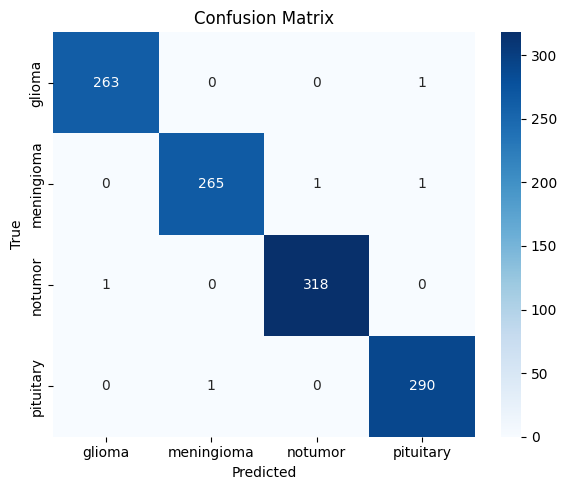

Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       264
  meningioma       1.00      0.99      0.99       267
     notumor       1.00      1.00      1.00       319
   pituitary       0.99      1.00      0.99       291

    accuracy                           1.00      1141
   macro avg       1.00      1.00      1.00      1141
weighted avg       1.00      1.00      1.00      1141



In [2]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 클래스 
class_names = list(train_generator.class_indices.keys())

# 예측 
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix 
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report 
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

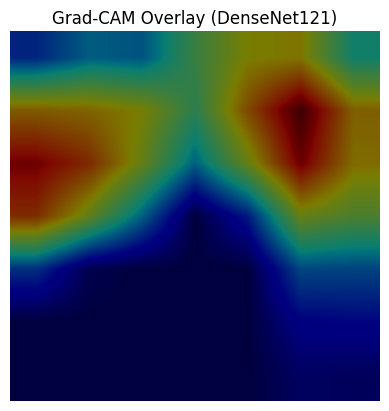

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# 대상 이미지 경로
IMG_PATH = 'dataset/segmentation/pituitarytumor/enh_712.png'
LAYER_NAME = 'conv5_block16_concat'  # DenseNet121 마지막 conv layer

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    arr = image.img_to_array(img) / 255.0
    return np.expand_dims(arr, axis=0), arr

img_tensor, raw_img = preprocess_image(IMG_PATH)

def get_gradcam_heatmap(model, img_tensor, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

# 시각화
heatmap = get_gradcam_heatmap(model, img_tensor, LAYER_NAME)
plt.imshow(raw_img.astype('uint8'))
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay (DenseNet121)")
plt.axis('off')
plt.show()

36/36 [==============================] - 8s 208ms/step


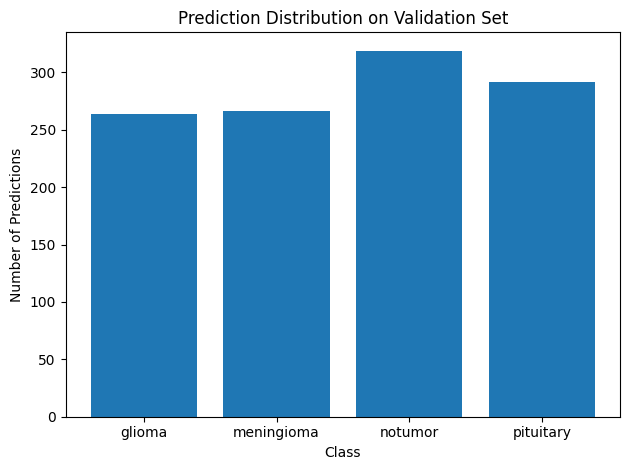

In [4]:
import matplotlib.pyplot as plt
import collections
import numpy as np

# 예측 클래스 분포 확인
predicted_classes = np.argmax(model.predict(val_generator), axis=1)
class_counts = collections.Counter(predicted_classes)

# 클래스 이름 정렬
class_labels = [k for k, v in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]
counts = [class_counts[i] for i in range(len(class_labels))]

# 시각화
plt.bar(class_labels, counts)
plt.title("Prediction Distribution on Validation Set")
plt.ylabel("Number of Predictions")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

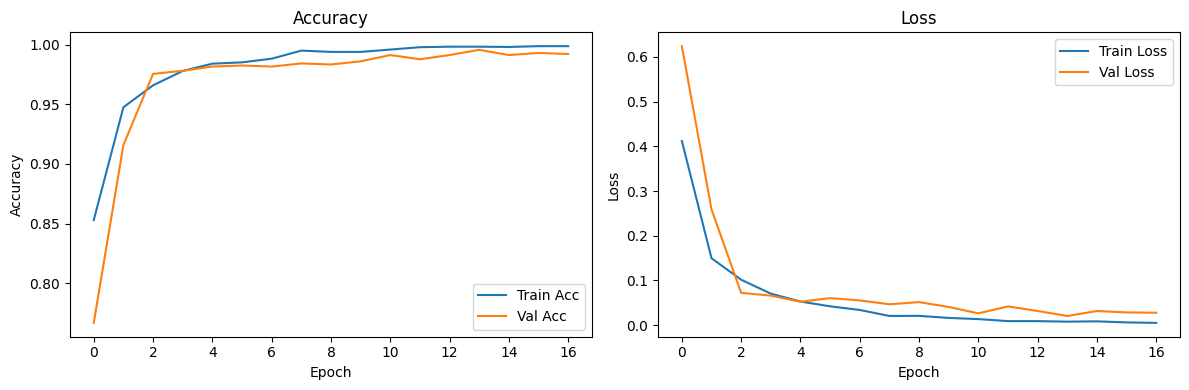

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

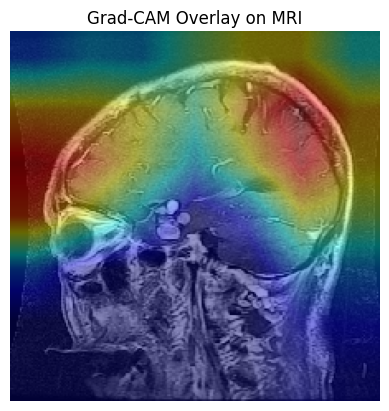

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# 이미지 로드 및 전처리
def load_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    arr = image.img_to_array(img) / 255.0
    return np.expand_dims(arr, axis=0), arr

# Grad-CAM 생성
def get_gradcam_heatmap(model, img_tensor, layer_name='conv5_block16_concat'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)
    return cv2.resize(heatmap, (224, 224))

# 시각화 함수 (MRI 이미지 위에 heatmap overlay)
def plot_gradcam_overlay(raw_img, heatmap, alpha=0.4):
    # heatmap 컬러맵 적용
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # 원본 이미지 정규화 및 dtype 정리
    if raw_img.max() <= 1.0:
        raw_img = np.uint8(raw_img * 255)

    # overlay
    overlay = cv2.addWeighted(raw_img.astype('uint8'), 1 - alpha, heatmap_color, alpha, 0)

    # 시각화
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay on MRI")
    plt.axis('off')
    plt.show()

# 실행 예시
IMG_PATH = 'dataset/segmentation/pituitarytumor/enh_712.png'

img_tensor, raw_img = load_image(IMG_PATH)
heatmap = get_gradcam_heatmap(model, img_tensor, layer_name='conv5_block16_concat')
plot_gradcam_overlay(raw_img, heatmap)

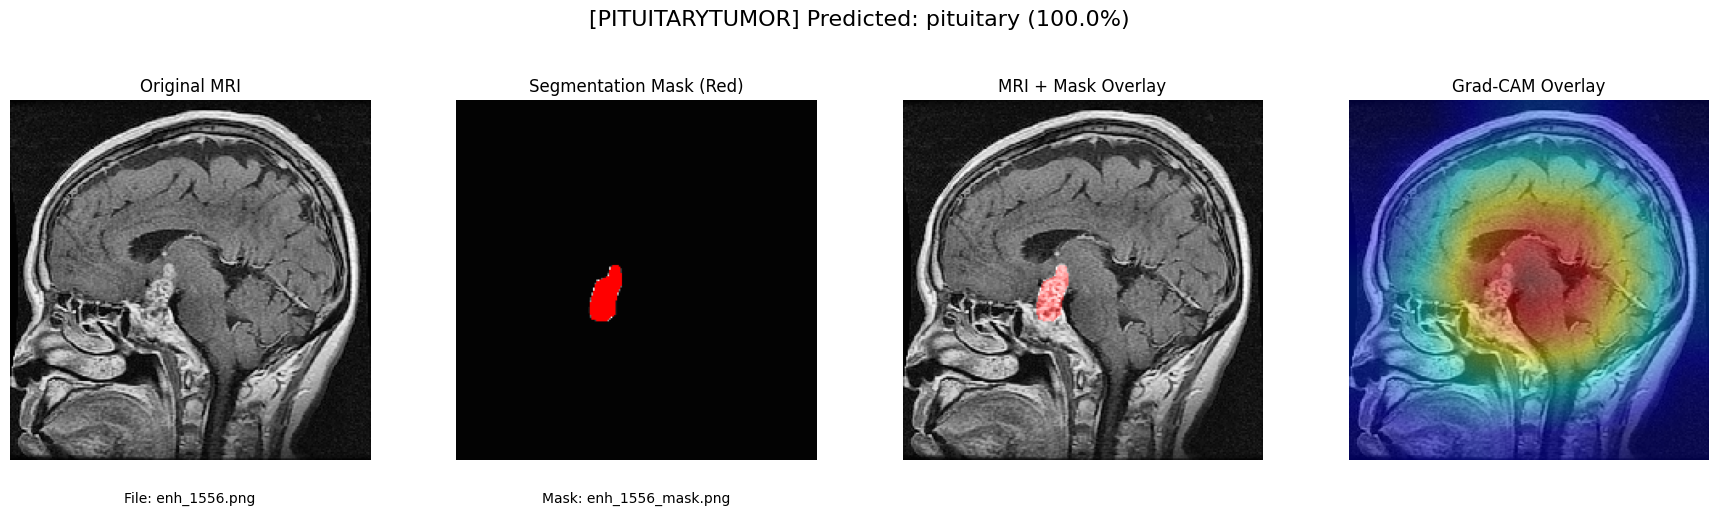

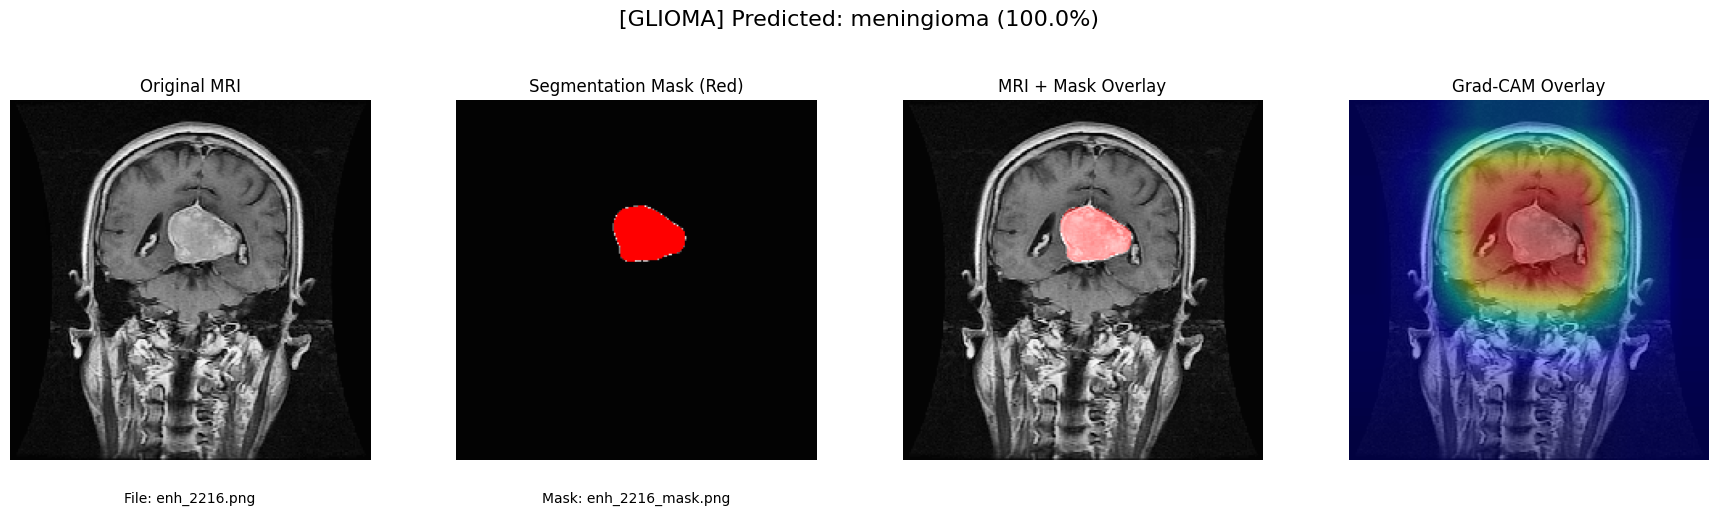

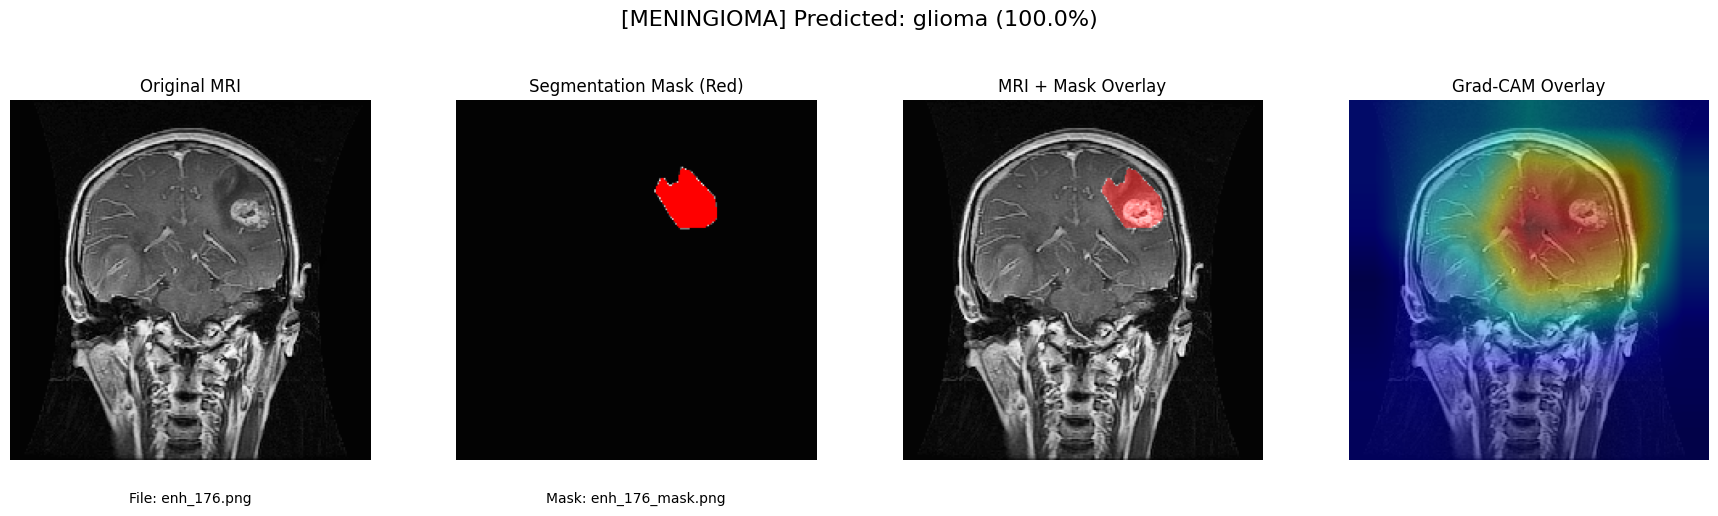

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.preprocessing import image

# 모델 로드
model = tf.keras.models.load_model('densenet121_finetuned.keras')
LAYER_NAME = 'conv5_block16_concat'
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']
SEG_DIR = 'dataset/segmentation'

# 이미지와 마스크 로드
def load_image_and_mask(img_path, mask_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    arr = image.img_to_array(img) / 255.0
    return np.expand_dims(arr, axis=0), np.uint8(arr * 255)

# Grad-CAM 생성
def get_gradcam_heatmap(model, img_tensor, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)
    return cv2.resize(heatmap, (224, 224)), predictions.numpy()[0], class_idx.numpy()

# 시각화
def plot_all_views(raw_img, heatmap, pred_probs, class_idx, class_names, filename, mask_path, tumor_type):
    # Grad-CAM overlay
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay_cam = cv2.addWeighted(raw_img, 0.6, heatmap_color, 0.4, 0)

    # Segmentation mask: 흰색 → 빨간색
    mask_rgb = cv2.imread(mask_path)
    mask_rgb = cv2.resize(mask_rgb, (224, 224))
    mask_rgb[np.all(mask_rgb == [255, 255, 255], axis=2)] = [255, 0, 0]

    # 빨간 마스크를 MRI에 오버레이
    mask_overlay = cv2.addWeighted(raw_img, 1.0, mask_rgb, 0.5, 0)

    # 텍스트 정보
    pred_class = class_names[class_idx]
    confidence = pred_probs[class_idx] * 100
    mask_fname = filename.replace('.png', '_mask.png')

    # 시각화
    fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    fig.suptitle(f"[{tumor_type.upper()}] Predicted: {pred_class} ({confidence:.1f}%)", fontsize=16)

    axs[0].imshow(raw_img)
    axs[0].set_title("Original MRI")
    axs[0].axis('off')
    axs[0].text(0.5, -0.12, f"File: {filename}", fontsize=10, ha='center', transform=axs[0].transAxes)

    axs[1].imshow(mask_rgb)
    axs[1].set_title("Segmentation Mask (Red)")
    axs[1].axis('off')
    axs[1].text(0.5, -0.12, f"Mask: {mask_fname}", fontsize=10, ha='center', transform=axs[1].transAxes)

    axs[2].imshow(mask_overlay)
    axs[2].set_title("MRI + Mask Overlay")
    axs[2].axis('off')

    axs[3].imshow(overlay_cam)
    axs[3].set_title("Grad-CAM Overlay")
    axs[3].axis('off')

    plt.tight_layout(rect=[0, 0.05, 1, 0.90])
    plt.show()

# 실행
tumor_classes = ['pituitarytumor', 'glioma', 'meningioma']
for cls in tumor_classes:
    folder = os.path.join(SEG_DIR, cls)
    img_files = [f for f in os.listdir(folder) if f.endswith('.png') and '_mask' not in f]
    if not img_files:
        continue

    img_file = random.choice(img_files)
    mask_file = img_file.replace('.png', '_mask.png')
    img_path = os.path.join(folder, img_file)
    mask_path = os.path.join(folder, mask_file)

    if not os.path.exists(mask_path):
        continue

    img_tensor, raw_img = load_image_and_mask(img_path, mask_path)
    heatmap, pred_probs, class_idx = get_gradcam_heatmap(model, img_tensor, LAYER_NAME)
    plot_all_views(raw_img, heatmap, pred_probs, class_idx, CLASS_NAMES, img_file, mask_path, tumor_type=cls)